# Part 3: Adding two numbers with a quantum computer
---

Build a function (quantum_sum) to add two numbers using the Draper adder algorithm. You will need the Quantum Fourier Transform (QFT). Many libraries offer a function to use it. For this task, you will need to build QFT from scratch.

In [1]:
import pennylane as qml
from pennylane import numpy as np

Adding two numbers using a quantum computer is done by applying a series of phase rotations to quantum states in Fourier basis. 

Define Quantum Fourier Transform function and its adjoint.

In [2]:
def qft(wires):
    n = len(wires)
    
    for j in range(n):
        qml.Hadamard(wires=wires[j])
        for k in range(j + 1, n):
            angle = np.pi / (2 ** (k - j))
            qml.CPhase(angle, wires=[wires[k], wires[j]])

    for i in range(n // 2):
        qml.SWAP(wires=[wires[i], wires[n - i - 1]])

def adjoint_qft(wires):
    n = len(wires)

    for i in reversed(range(n // 2)):
        qml.SWAP(wires=[wires[i], wires[n - i - 1]])

    for j in reversed(range(n)):
        for k in reversed(range(j + 1, n)):
            angle = -np.pi / (2 ** (k - j))
            qml.CPhase(angle, wires=[wires[k], wires[j]])
        qml.Hadamard(wires=wires[j])

To add an integer $k$ using a qubit, apply phase rotation gates
- with parameter $\frac{\pi}{2^{wires}}$, $k$ times 

    or

- with parameter $k \times \frac{\pi}{2^{wires}}$, one time

to each wire.

In [3]:
def add_k_fourier_basis(k, wires):
    for i in range(len(wires)):
        qml.RZ(k * np.pi / (2**i), wires=wires[i])

To optimize performance and reduce redundancy, we can generate only the minimum number of quantum wires required to represent the sum of two integers based on their binary representations.

In [4]:
def generate_wires(m, k):
    bits_m = m.bit_length()
    bits_k = k.bit_length()
    total = m + k
    bits_solution = total.bit_length()
    wires_m = list(range(bits_m))
    wires_k = list(range(bits_m, bits_m + bits_k))
    wires_solution = list(range(bits_m + bits_k, bits_m + bits_k + bits_solution))
    
    return wires_m, wires_k, wires_solution

In [5]:
m = 4
k = 17
wires_m, wires_k, wires_solution = generate_wires(m, k)

print("wires_m:", wires_m)
print("wires_k:", wires_k)
print("wires_solution:", wires_solution)

wires_m: [0, 1, 2]
wires_k: [3, 4, 5, 6, 7]
wires_solution: [8, 9, 10, 11, 12]


Put QFT and phase rotation gates together to add two numbers!

In [6]:
dev = qml.device("default.qubit", wires=wires_m + wires_k + wires_solution, shots=1)

n_wires = len(dev.wires) 

def addition(wires_m, wires_k, wires_solution):
    qft(wires=wires_solution)
    qml.Barrier()

    for i in range(len(wires_m)):
        qml.ctrl(add_k_fourier_basis, control=wires_m[i])(2 **(len(wires_m) - i - 1), wires_solution)

    for i in range(len(wires_k)):
        qml.ctrl(add_k_fourier_basis, control=wires_k[i])(2 **(len(wires_k) - i - 1), wires_solution)

    qml.Barrier()
    adjoint_qft(wires=wires_solution)


@qml.qnode(dev)
def quantum_sum(m, k, wires_m, wires_k, wires_solution):
    # BasisEmbedding encodes the binary feature into a basis state
    # i.e, operates a PauliX on the qubit if the corresponding bit is 1 in the binary representation of the number 
    # Example: 4 -> 100 -> PauliX on the first qubit
    qml.BasisEmbedding(m, wires=wires_m)
    qml.BasisEmbedding(k, wires=wires_k)

    addition(wires_m, wires_k, wires_solution)

    return qml.sample(wires=wires_solution)

sample = quantum_sum(m, k, wires_m, wires_k, wires_solution)

print(f"The ket representation of the sum of {m} and {k} is {sample} which is equal to {int(''.join(map(str, sample)), 2)}.")

The ket representation of the sum of 4 and 17 is [1 0 1 0 1] which is equal to 21.


The function successfully returns the correct result of 21.

Circuit for adding $m$ and $k$:
(Image can be found in the images folder)

(<Figure size 7900x1400 with 1 Axes>, <Axes: >)

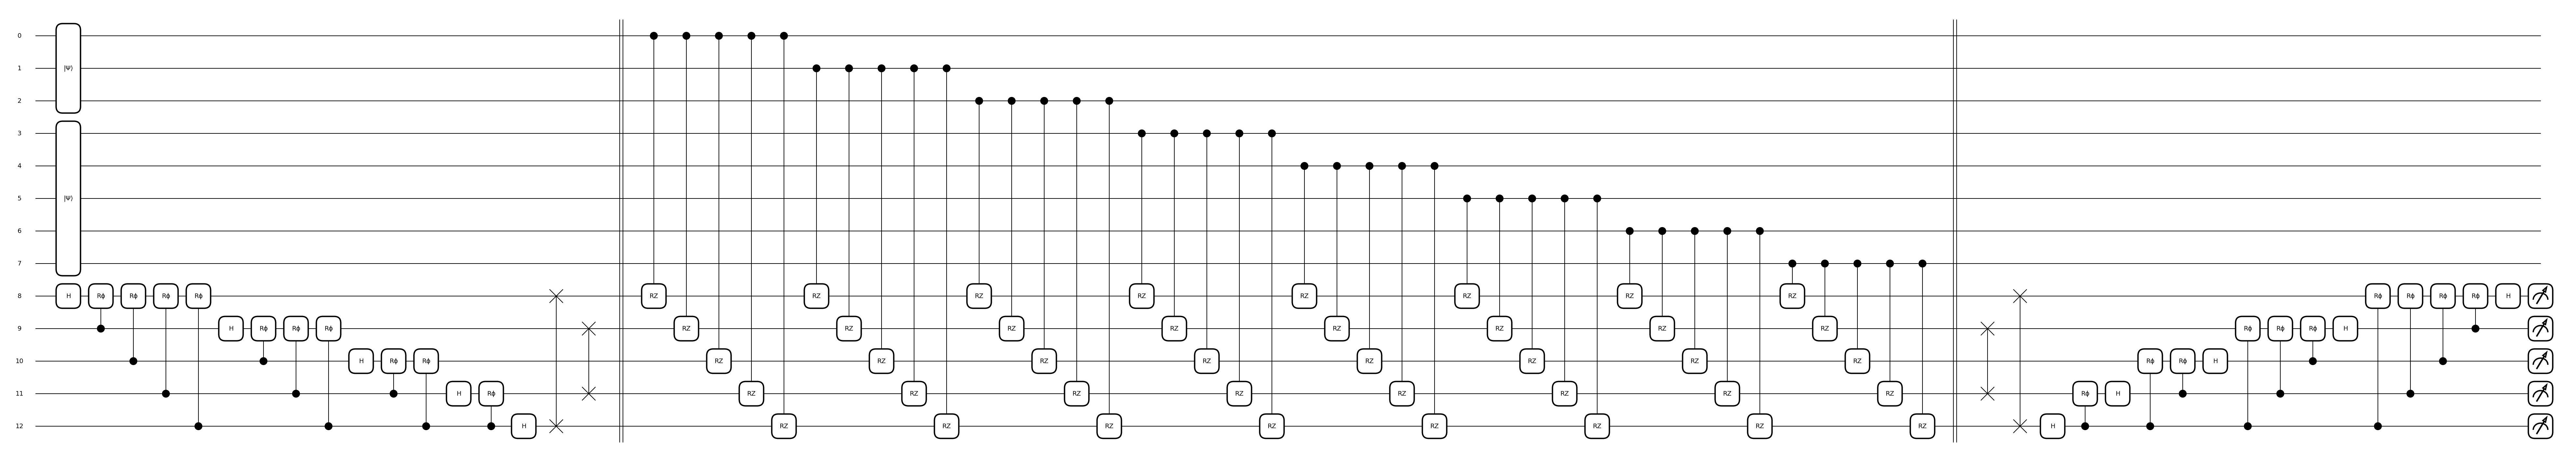

In [7]:
qml.draw_mpl(quantum_sum, show_all_wires=True)(m, k, wires_m, wires_k, wires_solution)

### References

- Lidia Ruiz-Perez, Juan Carlos Garcia-Escartin, "Quantum arithmetic with the Quantum Fourier Transform". arXiv:1411.5949 [quant-ph]
- Thomas G. Draper, “Addition on a Quantum Computer”. arXiv:quant-ph/0008033.

Proceed to Part_4.ipynb